In [1]:
import sys
sys.path.insert(0, f"/home/txm/gpu_txmdata/integration/package/v1.0/scMIAC/")

In [2]:
import anndata as ad
import scanpy as sc

from scmiac.scmiac import find_anchors,preprocess,train_model,model_inference
from scmiac.preprocess import run_umap

In [3]:
adata_rna_file = "../../demo_data/adata_rna_10x.h5ad"
adata_atac_file = "../../demo_data/adata_atac_10x.h5ad"

device = "cuda:2"

In [4]:
adata_rna = sc.read(adata_rna_file)
print(adata_rna)
adata_atac = sc.read(adata_atac_file)
print(adata_atac)

AnnData object with n_obs × n_vars = 10412 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'modality'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 10412 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'modality', 'pred'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_umap', 'lsi49', 'lsi49_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [5]:
anchor_df = find_anchors(
    adata_rna,
    adata_atac
)

Number of common genes: 18353
Find anchors across datasets.
1. prepare input matrix for CCA
2. run cca between datasets
Run CCA
non zero dims 30
3. normalize CCV per sample/row
4. find MNN of U and V to find anchors
Find Anchors using k=30
5. filter anchors by high dimensional neighbors
6. score anchors with snn and local structure preservation
Number of anchor pairs: 18291
Number of anchors pairs after cell type filtering: 15721
Number of RNA anchors: 6984; Number of ATAC anchors: 6691


In [6]:
rna_vae, atac_vae, all_cells_loader, anchor_cells_loader = preprocess(
    adata_rna,
    adata_atac,
    anchor_df,
    rna_latent_key = "X_pca",
    atac_latent_key = "lsi49",
    device = device)

In [7]:
rna_vae, atac_vae = train_model(
    rna_vae, 
    atac_vae, 
    all_cells_loader, 
    anchor_cells_loader, 
    device = device, 
    num_epoches = 2000,
    print_step = 100)

Epoch 0, Total: 3333.31, RNA Reco: 1008.25, RNA KLD: 0.35, ATAC Reco: 987.04, ATAC KLD: 0.31, Contra: 1337.36


Epoch 100, Total: 1670.29, RNA Reco: 236.91, RNA KLD: 66.94, ATAC Reco: 205.63, ATAC KLD: 69.01, Contra: 1091.80
Epoch 200, Total: 1463.11, RNA Reco: 125.06, RNA KLD: 75.47, ATAC Reco: 99.33, ATAC KLD: 76.22, Contra: 1087.03
Epoch 300, Total: 1428.74, RNA Reco: 105.28, RNA KLD: 77.39, ATAC Reco: 84.73, ATAC KLD: 77.54, Contra: 1083.79
Epoch 400, Total: 1416.02, RNA Reco: 99.40, RNA KLD: 78.23, ATAC Reco: 78.92, ATAC KLD: 77.90, Contra: 1081.57
Epoch 500, Total: 1408.42, RNA Reco: 95.83, RNA KLD: 78.36, ATAC Reco: 75.88, ATAC KLD: 78.31, Contra: 1080.04
Epoch 600, Total: 1403.36, RNA Reco: 93.40, RNA KLD: 78.23, ATAC Reco: 73.78, ATAC KLD: 78.33, Contra: 1079.61
Epoch 700, Total: 1399.53, RNA Reco: 91.80, RNA KLD: 78.42, ATAC Reco: 72.22, ATAC KLD: 78.27, Contra: 1078.82
Epoch 800, Total: 1397.36, RNA Reco: 90.51, RNA KLD: 78.62, ATAC Reco: 71.13, ATAC KLD: 78.32, Contra: 1078.78
Epoch 900, Total: 1395.13, RNA Reco: 89.36, RNA KLD: 78.58, ATAC Reco: 70.19, ATAC KLD: 78.29, Contra: 1078.

In [8]:
rna_embeddings, atac_embeddings = model_inference(
    rna_vae, 
    atac_vae, 
    all_cells_loader)

In [9]:
adata_rna.obsm['scmiac_latent'] = rna_embeddings
adata_atac.obsm['scmiac_latent'] = atac_embeddings

In [10]:
adata_cm = ad.concat([adata_rna, adata_atac],join='outer')

/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
adata_cm = run_umap(adata_cm,'scmiac_latent')

UMAP embedding is stored in adata.obsm['scmiac_latent_umap']


/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


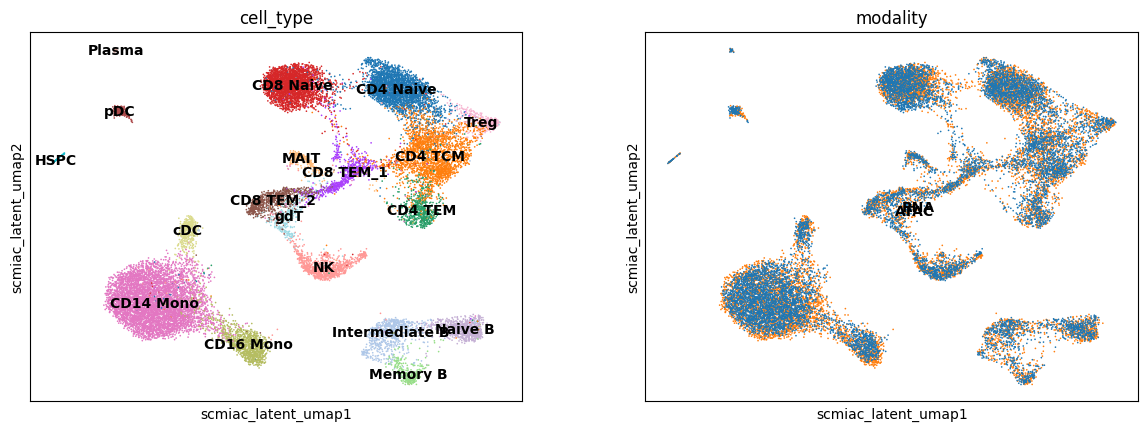

In [12]:
sc.pl.embedding(adata_cm, basis='scmiac_latent_umap', color=['cell_type','modality'],legend_loc = 'on data')